In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from scipy.stats import norm
import torch
import torch.nn as nn
import random
import copy
import math

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Supported by cuda: {torch.cuda.is_available()}")
print(f"cuda version: {torch.version.cuda}")
cuda_id = torch.cuda.current_device()
print(f"Name of cuda device: {torch.cuda.get_device_name(cuda_id)}")

Supported by cuda: True
cuda version: 11.1
Name of cuda device: NVIDIA GeForce GTX 1080 Ti


In [5]:
np.set_printoptions(threshold=2**11)

In [6]:
df = pd.read_csv('covid_compound_info.csv')

<ipython-input-6-777b782f6dc7>:1: DtypeWarning: Columns (1881,1882) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('covid_compound_info.csv')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5737 entries, 0 to 5736
Columns: 1884 entries, cbkid to morgan_fingerprint
dtypes: float64(1878), object(6)
memory usage: 82.5+ MB


In [8]:
# List of indexes with morphological data
morph_i = [i for i in range(1,1879)]
morph_i = df.columns[morph_i]
print(f'num of features:\t{len(morph_i)}')

num of features:	1878


In [9]:
# Min Max normalize the data
df.loc[:,morph_i] = (df.loc[:,morph_i]-df.loc[:,morph_i].mean())/df.loc[:,morph_i].std()

In [198]:
# Z Score normalize the data
"""
dmso_median = df.iloc[dmso_i, morph_i].median()
dmso_mads = (df.iloc[dmso_i, morph_i] - df.iloc[dmso_i, morph_i].median()).abs().median()
df.iloc[:, morph_i] = (df.iloc[:, morph_i] - dmso_median)/(dmso_mads+0.000000000000001)
"""

In [10]:
df.head()

,cbkid,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,smiles,name,mode_of_action,target,morgan_fingerprint
0,CBK000155,-0.672208,-0.042178,-0.013539,-0.258297,0.063702,-0.248996,0.054097,-0.253403,0.058512,...,-0.908570,0.986054,1.173090,0.758270,0.623500,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,BRL-37344,adrenergic receptor agonist,ADRB1|ADRB2|ADRB3,0100000000000001000000000000000001000000000000...
1,CBK000156,0.422168,-0.346389,-0.399594,-0.492103,-0.264450,-0.477399,-0.251773,-0.484836,-0.258669,...,0.629231,-0.082224,0.383009,-2.093276,-0.657570,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,CGP-12177,adrenergic receptor agonist,ADRB1|ADRB2|ADRB3,0100000000000001000000001000000001000000000000...
2,CBK000161,0.395942,-0.151598,-0.134403,-0.513562,-0.724350,-0.511271,-0.718577,-0.512309,-0.722348,...,-0.246500,-0.921100,1.236204,0.183033,-1.206734,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,procaterol,adrenergic receptor agonist,ADRB2,0100100000000000000000000000000001000000000000...
3,CBK000162,-0.032411,-0.729416,-0.740183,2.712291,0.489569,2.722763,0.526429,2.717305,0.508454,...,0.129693,-1.525688,-0.495248,1.188769,0.907037,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,"ICI-118,551",adrenergic receptor antagonist,ADRB2|ADRB3,1100100000000000000000000000000001000000000000...
4,CBK000164,0.216733,-0.543885,-0.540221,0.860705,0.898103,0.878953,0.916956,0.869954,0.907997,...,1.795842,1.128857,-0.847767,0.898986,-0.163336,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,BISOPROLOL FUMARATE,adrenergic receptor antagonist,ADRB1,0100100000000100000000000000000001000000000000...


In [11]:
# Make list of indexes of remedsivir, dmso, healthy, & compound treated cells
remdesivir_i = df.index[df['cbkid']=='Remdesivir'].tolist()
dmso_i = df.index[df['cbkid']=='DMSO'].tolist()
healthy_i = df.index[df['cbkid']=='Uninfected'].tolist()
compounds_i = [i for i in range(0, 5737) if i not in remdesivir_i+dmso_i+healthy_i]
print(f'num healthy:\t{len(healthy_i)}')
print(f'num dmso:\t{len(dmso_i)}')
print(f'num remdesivir:\t{len(remdesivir_i)}')
print(f'num compounds:\t{len(compounds_i)}')
print(f'total:\t{len(healthy_i)+len(dmso_i)+len(remdesivir_i)+len(compounds_i)}')

num healthy:	256
num dmso:	188
num remdesivir:	158
num compounds:	5135
total:	5737


In [12]:
pca = PCA(n_components = 2)
train_data = (df.loc[dmso_i+healthy_i,morph_i]-df.loc[dmso_i+healthy_i,morph_i].mean())/df.loc[dmso_i+healthy_i,morph_i].std()
pca.fit(train_data)

PCA(n_components=2)

In [13]:
pca_full = PCA(n_components = 2)
train_full_data = (df.loc[:,morph_i]-df.loc[:,morph_i].mean())/df.loc[:,morph_i].std()
pca_full.fit(train_full_data)
print("PCA information:")
print(f"Explained variance:\t{pca_full.explained_variance_}")
print(f"Explained variance ratio: {pca_full.explained_variance_ratio_}")
print(f"Singular values:\t{pca_full.singular_values_}")
print(f"noise variance:\t\t{pca_full.noise_variance_}")

PCA information:
Explained variance:	[743.34525037 152.63247552]
Explained variance ratio: [0.39581749 0.08127395]
Singular values:	[2064.90395808  935.68150542]
noise variance:		0.5234660309758844


In [14]:
print("PCA information:")
print(f"Explained variance:\t{pca.explained_variance_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Singular values:\t{pca.singular_values_}")
print(f"noise variance:\t\t{pca.noise_variance_}")

PCA information:
Explained variance:	[955.32708652 110.8617697 ]
Explained variance ratio: [0.50869387 0.05903183]
Singular values:	[650.54584721 221.61174152]
noise variance:		1.8366767958884422


In [15]:
# Project the four groups onto the 2D PCA space
pca_remdesivir = pca.transform(df.loc[remdesivir_i, morph_i])
pca_compounds = pca.transform(df.loc[compounds_i, morph_i])
pca_dmso = pca.transform(df.loc[dmso_i, morph_i])
pca_healthy = pca.transform(df.loc[healthy_i, morph_i])

# Add the PCA results to df, first add them to an intermediate np array
pca_results = np.zeros([5737, 2])
for counter, index in enumerate(healthy_i):
    pca_results[index,:] = pca_healthy[counter,:]
for counter, index in enumerate(dmso_i):
    pca_results[index,:] = pca_dmso[counter,:]
for counter, index in enumerate(compounds_i):
    pca_results[index,:] = pca_compounds[counter,:]
for counter, index in enumerate(remdesivir_i):
    pca_results[index,:] = pca_remdesivir[counter,:]
df['pca1'] = pca_results[:,0]
df['pca2'] = pca_results[:,1]

# Normalize pca results
df.iloc[:,[-2, -1]] = (df.iloc[:,[-2, -1]]-df.iloc[:,[-2, -1]].mean())/df.iloc[:,[-2, -1]].std()

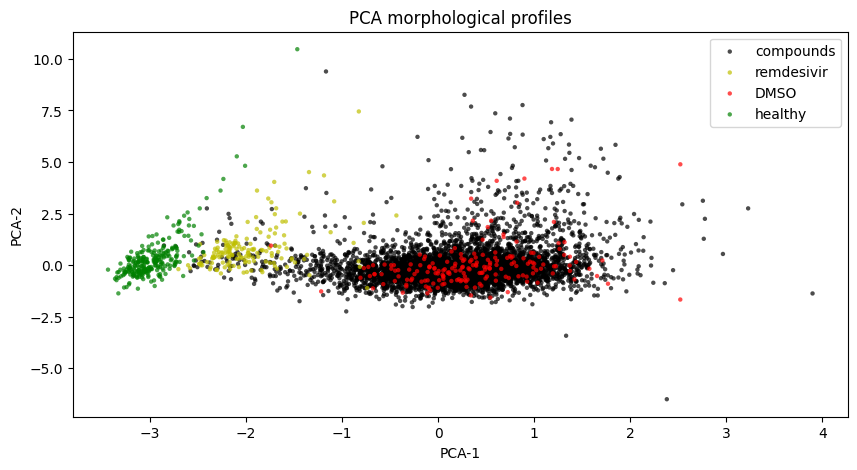

In [16]:
alpha=0.7
edgecolor = 'none'
size = 10

plt.rcParams['figure.figsize'] = [10, 5]
#plt.xlim((-60, 120))
#plt.ylim((-40, 80))
plt.scatter(df.iloc[compounds_i, -2], df.iloc[compounds_i, -1], s=size, c='k', edgecolor=edgecolor, alpha=alpha, label='compounds')
plt.scatter(df.iloc[remdesivir_i, -2], df.iloc[remdesivir_i, -1], s=size, c='y', edgecolor=edgecolor, alpha=alpha, label='remdesivir')
plt.scatter(df.iloc[dmso_i, -2], df.iloc[dmso_i, -1], s=size, c='r', edgecolor=edgecolor, alpha=alpha, label='DMSO')
plt.scatter(df.iloc[healthy_i, -2], df.iloc[healthy_i, -1], s=size, c='g', edgecolor=edgecolor, alpha=alpha, label='healthy')
plt.title('PCA morphological profiles')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
#plt.savefig('PCA_morphological_profiles.png')
plt.show()

In [17]:
df.loc[remdesivir_i[0], 'smiles']

'CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4'

In [18]:
# Split into train, validate, & test
train_split = 0.7
valid_split = 0.1
test_split = 0.2
n_tot = len(compounds_i)
n_train = (int)(train_split * n_tot)
n_valid = (int)(valid_split * n_tot)
n_test = n_tot - n_train - n_valid
indexes_random = list(range(n_tot))
compounds_random_i = copy.deepcopy(compounds_i)
random.Random(32).shuffle(compounds_random_i)
train_i, test_i = compounds_random_i[:n_train], compounds_random_i[n_train:]
print(f"Total compound set: {n_tot}")
print(f"Training set size: {len(train_i)}")
print(f"Testing set size: {len(test_i)}")

Total compound set: 5135
Training set size: 4621
Testing set size: 514


Dropping 1749 rows
Droped: 0 points
Droped: 100 points
Droped: 200 points
Droped: 300 points
Droped: 400 points
Droped: 500 points
Droped: 600 points
Droped: 700 points
Droped: 800 points
Droped: 900 points
Droped: 1000 points
Droped: 1100 points
Droped: 1200 points
Droped: 1300 points
Droped: 1400 points
Droped: 1500 points
Droped: 1600 points
Droped: 1700 points
Complete train set size: 4621
Thinned train set size: 2872


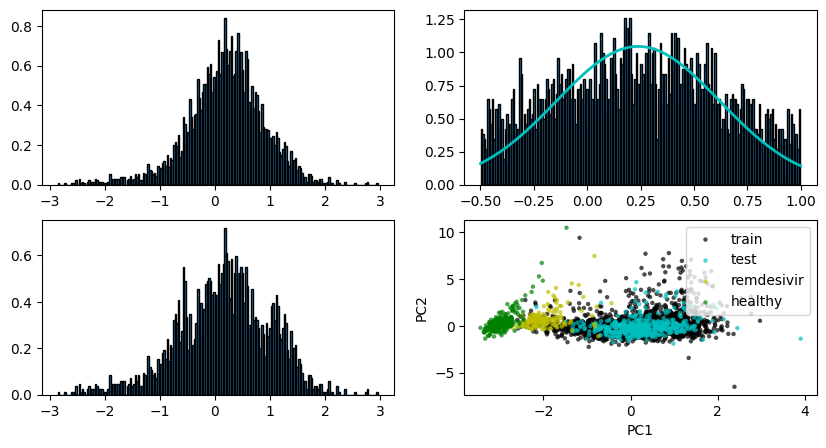

In [15]:
# Remove 50% of all samples in the main cluster to make more balanced dataset
fig, ax = plt.subplots(2, 2)

# Between -0.5 and 1 is death_zone reduce everything by 50%
percent_drop = 0.5
min_value = -0.5
max_value = 1
# Train data before droping
ax[0, 0].hist(df.loc[train_i,'pca1'], 200, edgecolor='k', density=True)
train_thined_i = copy.deepcopy(train_i)
# DataFrame with index of all samples inside min_value and max_value
remove_zone = [i for i in train_thined_i if min_value < df.loc[i,'pca1'] < max_value]
mu, std = norm.fit(df.loc[remove_zone,'pca1'])
num_drop = int(len(remove_zone) * percent_drop)
print(f"Dropping {num_drop} rows")
# Samples that can be dropped from
ax[0, 1].hist(df.loc[remove_zone,'pca1'], 200, edgecolor='k', density=True)
x = np.linspace(min_value, max_value, 100)
p = norm.pdf(x, loc=mu, scale=std)
ax[0, 1].plot(x, p, 'c', linewidth=2)
dropped = []
for i in range(num_drop):
    if i%100==0:
        print(f"Droped: {i} points")
    random_num = np.random.normal(loc=mu, scale=std)
    while (not(min_value < random_num and random_num < max_value)):
        random_num = np.random.normal(loc=mu, scale=std)
    value_to_drop = (df.loc[remove_zone, 'pca1']-random_num).abs().argsort()[:1]
    train_thined_i.remove(value_to_drop.index)
    remove_zone.remove(value_to_drop.index)
    
print(f"Complete train set size: {len(train_i)}")
print(f"Thinned train set size: {len(train_thined_i)}")

ax[1, 0].hist(df.loc[train_thined_i,'pca1'], 200, edgecolor='k', density=True)
ax[1, 1].scatter(df.loc[train_thined_i,'pca1'], df.loc[train_thined_i,'pca2'], s=size, c='k', edgecolor=edgecolor, alpha=alpha, label='train')
ax[1, 1].scatter(df.loc[test_i,'pca1'], df.loc[test_i,'pca2'], s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
ax[1, 1].scatter(df.loc[remdesivir_i,'pca1'], df.loc[remdesivir_i, 'pca2'], s=size, c='y', edgecolor=edgecolor, alpha=alpha, label='remdesivir')
#ax[1, 1].scatter(df.iloc[dmso_i,-2], df.iloc[dmso_i, -1], s=size, c='r', edgecolor=edgecolor, alpha=alpha, label='DMSO')
ax[1, 1].scatter(df.loc[healthy_i,'pca1'], df.loc[healthy_i, 'pca2'], s=size, c='g', edgecolor=edgecolor, alpha=alpha, label='healthy')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()


plt.show()


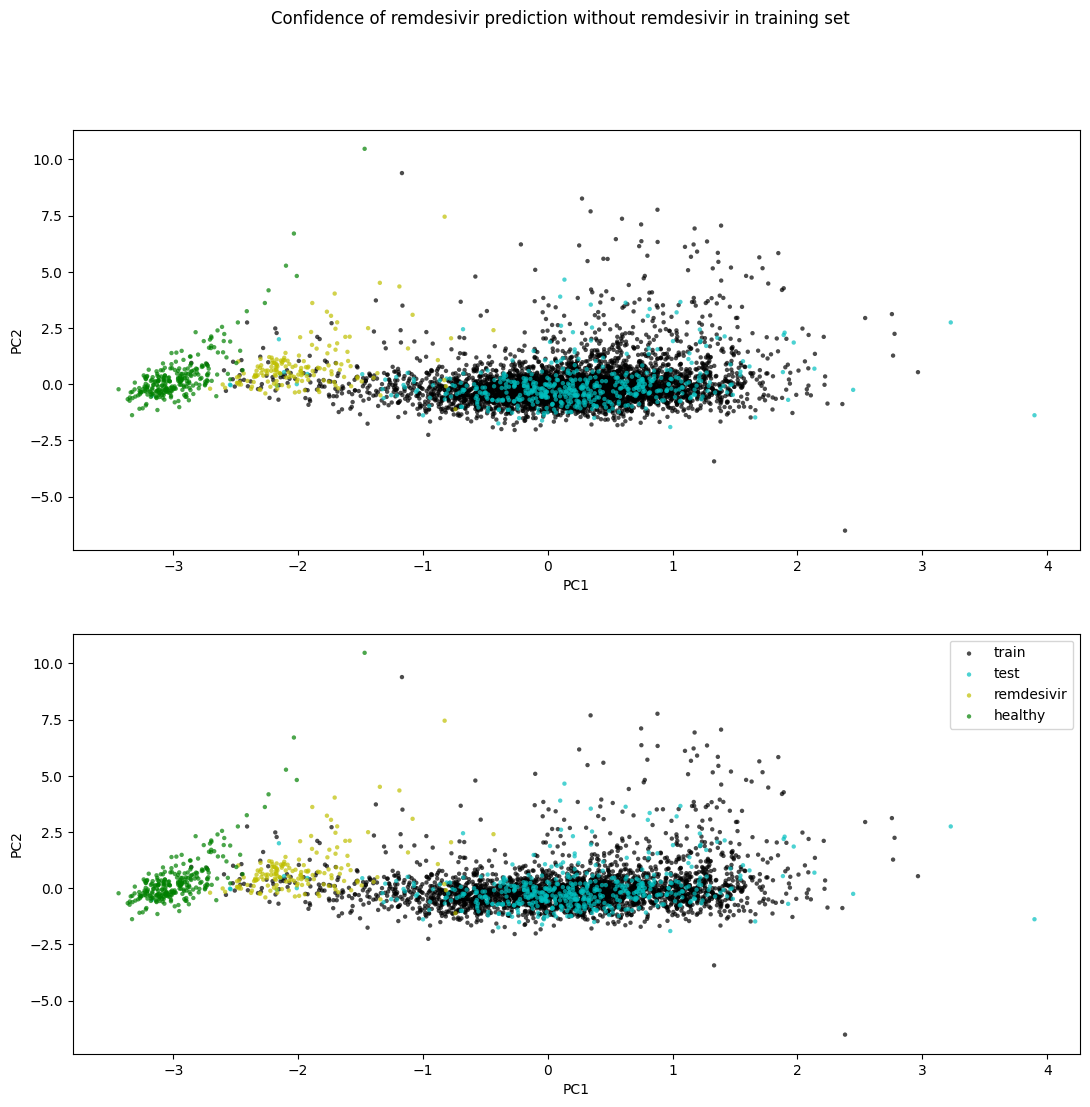

In [16]:
plt.rcParams['figure.figsize'] = [13, 12]
fig, ax = plt.subplots(2)
linewidth = 2
edgecolor_box = 'c'

# CPSign trained on compounds predicting remdesivir
fig.suptitle('Confidence of remdesivir prediction without remdesivir in training set')

# Model 9
ax[0].scatter(df.loc[train_i, 'pca1'], df.loc[train_i, 'pca2'], s=size, c='k', edgecolor=edgecolor, alpha=alpha, label='train')
ax[0].scatter(df.loc[test_i, 'pca1'], df.loc[test_i, 'pca2'], s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
ax[0].scatter(df.loc[remdesivir_i, 'pca1'], df.loc[remdesivir_i, 'pca2'], s=size, c='y', edgecolor=edgecolor, alpha=alpha, label='remdesivir')
#ax[0].scatter(df.iloc[dmso_i,-2], df.iloc[dmso_i, -1], s=size, c='r', edgecolor=edgecolor, alpha=alpha, label='DMSO')
ax[0].scatter(df.loc[healthy_i, 'pca1'], df.loc[healthy_i, 'pca2'], s=size, c='g', edgecolor=edgecolor, alpha=alpha, label='healthy')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].scatter(df.loc[train_thined_i,'pca1'], df.loc[train_thined_i,'pca2'], s=size, c='k', edgecolor=edgecolor, alpha=alpha, label='train')
ax[1].scatter(df.loc[test_i,'pca1'], df.loc[test_i,'pca2'], s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
ax[1].scatter(df.loc[remdesivir_i,'pca1'], df.loc[remdesivir_i, 'pca2'], s=size, c='y', edgecolor=edgecolor, alpha=alpha, label='remdesivir')
#ax[1, 1].scatter(df.iloc[dmso_i,-2], df.iloc[dmso_i, -1], s=size, c='r', edgecolor=edgecolor, alpha=alpha, label='DMSO')
ax[1].scatter(df.loc[healthy_i,'pca1'], df.loc[healthy_i, 'pca2'], s=size, c='g', edgecolor=edgecolor, alpha=alpha, label='healthy')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

Find the extended connectivity fingerprint

In [788]:
# Download the thined dataset for CPSign
df.loc[train_thined_i, ['smiles', 'pca1', 'cutoff-0.8']].to_csv('train_thined2.csv', sep='\t', index=False)
df.loc[test_i, ['smiles', 'pca1', 'cutoff-0.8']].to_csv('test_thined2.csv', sep='\t', index=False)

In [17]:
# Define function to convert SMILES to a fingerprint
def ECFP_from_smiles(smiles, R=2, L=2**10, use_features=False, use_chirality=False):
    molecules = AllChem.MolFromSmiles(smiles)
    feature_list = AllChem.GetMorganFingerprintAsBitVect(molecules, radius=R, nBits=L, useFeatures=use_features, useChirality=use_chirality)
    #feature_list = AllChem.GetMorganFingerprint(molecules, 2)
    return np.array2string(np.array(feature_list), separator='')[1:-1].replace('\n', '').replace(' ', '')

In [18]:
# Check length of fingerprint
len(ECFP_from_smiles(df.loc[compounds_i[0], 'smiles'], R=2, L=2**10))

1024

In [19]:
# New column for the fingerprints
df['fingerprint'] = np.nan
df.loc[compounds_i, 'fingerprint'] = df.loc[compounds_i, 'smiles'].apply(lambda smiles: ECFP_from_smiles(smiles, R=2, L=2**10))

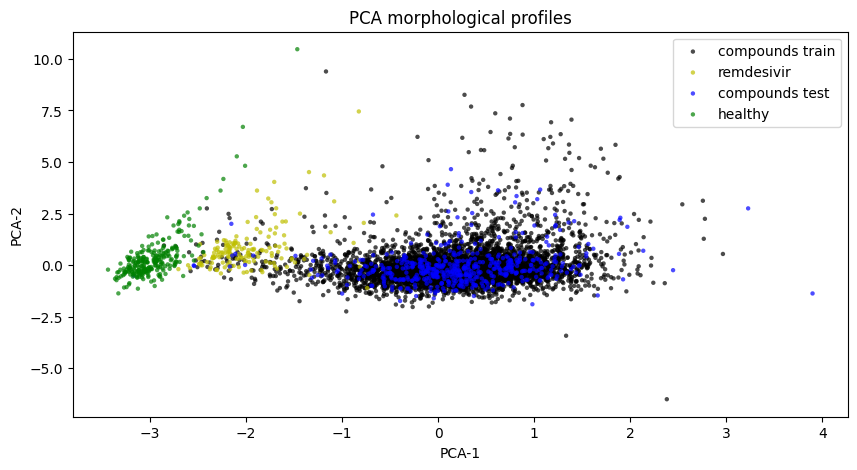

In [20]:
alpha=0.7
edgecolor = 'none'
size = 10

plt.rcParams['figure.figsize'] = [10, 5]
#plt.xlim((-60, 120))
#plt.ylim((-40, 80))
plt.scatter(df.loc[train_i,'pca1'], df.loc[train_i,'pca2'], s=size, c='k', edgecolor=edgecolor, alpha=alpha, label='compounds train')
plt.scatter(df.loc[remdesivir_i,'pca1'], df.loc[remdesivir_i,'pca2'], s=size, c='y', edgecolor=edgecolor, alpha=alpha, label='remdesivir')
plt.scatter(df.loc[test_i,'pca1'], df.loc[test_i,'pca2'], s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='compounds test')
#plt.scatter(df.loc[dmso_i,'pca1'], df.loc[dmso_i,'pca2'], s=size, c='r', edgecolor=edgecolor, alpha=alpha, label='DMSO')
plt.scatter(df.loc[healthy_i,'pca1'], df.loc[healthy_i,'pca2'], s=size, c='g', edgecolor=edgecolor, alpha=alpha, label='healthy')
plt.title('PCA morphological profiles')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
plt.savefig('PCA_morphological_profiles.png')
plt.show()

# REGRESSION

In [114]:
class MyDatasetFinger(torch.utils.data.Dataset):
    # Holds fingerprint as x, converts it from str to list of ints
    # as y PCA1
    def __init__(self, df, rows, X, Y, scale=False, get_index=False):
        self.x = df.loc[rows, X].apply(lambda finger: list(map(float, [*finger])))
        #self.x = df.loc[rows, X].apply(lambda finger: [*finger])
        self.y = df.loc[rows, Y]
        # Normalize the Y values
        if scale:
#            absolute_largest = self.y.abs().max()
            self.y = self.y / scale
#            for column in self.y.columns:
#                self.y[column] = (self.y[column] - self.y[column].mean()) / self.y[column].std()
        # Index in original df
        self.get_index = get_index
        self.index = rows
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if self.get_index:
            return self.x.iloc[idx], self.y.iloc[idx], self.index[idx]
        else:
            return self.x.iloc[idx], self.y.iloc[idx]

In [115]:
class FeedForwardNeuralNetModelReg(nn.Module):
    def __init__(self, input_dim, h_layers, output_dim, dropout=0.2, activation=nn.LeakyReLU()):
        super(FeedForwardNeuralNetModelReg, self).__init__()
        
        
        self.fc1 = nn.Linear(input_dim, h_layers[0])
        #self.batch_norm = nn.BatchNorm1d(h_layers[0])
        self.activation1 = activation
        if activation != nn.SELU():
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.AlphaDropout(dropout)
        self.dropout1 = self.dropout
        self.hidden_layers = nn.ModuleList()
        for index, n_nodes in enumerate(h_layers[:-1]):
            self.hidden_layers.append(nn.Linear(h_layers[index], h_layers[index+1]))
            #self.hidden_layers.append(nn.BatchNorm1d(h_layers[index+1]))
            self.hidden_layers.append(activation)
            self.hidden_layers.append(self.dropout)
            #self.hidden_layers.append(nn.AlphaDropout(dropout))
            #self.hidden_layers.append(nn.Dropout(dropout))
        self.fc_out = nn.Linear(h_layers[-1], output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        #x = self.batch_norm(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        for layer in self.hidden_layers:
            x = layer(x)
        #nn.functional.batch_norm()
        x = self.fc_out(x)
        return x.to(device)

In [145]:
# Create a NN that predics the coordinates in the 2D PCA space given the Morgan fingerprint

# Create iterable datasets
batch_size = 32
epochs = 20
# Scale data between [-1, 1]
scale_value = df.loc[compounds_i, 'pca1'].abs().max()
iterations = epochs * len(train_i) / batch_size
train_dataset = MyDatasetFinger(df, train_i, 'fingerprint', 'pca1')
test_dataset = MyDatasetFinger(df, test_i, 'fingerprint', 'pca1')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=n_test, shuffle=False)

# Create model
activation = nn.LeakyReLU()
input_dim = len(df.loc[compounds_i[0], 'fingerprint']) #1024
hidden_nodes = [500, 100]
output_dim = 1
dropout = 0.2
model1 = FeedForwardNeuralNetModelReg(input_dim, hidden_nodes, output_dim, dropout=dropout, activation=activation)
model1 = model1.to(device)

# MSELoss for multi-output regression
criterion = nn.MSELoss()

learning_rate = 0.0001
weight_decay = 0.015# l2 regression
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=weight_decay)

iter = 0
loss_values = []
loss_values_test = []
best_model = np.nan
best_loss = math.inf

print(next(model1.parameters()).device)

for epoch in range(epochs):
    running_loss = 0.0
    model1.train()
    model1 = model1.to(device)
    for i, (fingerprints, PCA1) in enumerate(train_loader):
        batch_size = len(fingerprints[0])
        #fingerprints = torch.stack(fingerprints).view(batch_size, 1024).requires_grad_().float()

        fingerprints = torch.transpose(torch.stack(fingerprints), 1, 0).float().to(device)
        PCA = PCA1.float().to(device)
        optimizer.zero_grad()
        

        #print(f"target is cuda: {PCA1.is_cuda}")
        #print(f"fingerprint is cuda: {fingerprints.is_cuda}")
        outputs = model1(fingerprints)

        loss = criterion(outputs, PCA.view([len(PCA), 1]))
        running_loss += loss.item() * batch_size
        
        loss.backward()
        
        optimizer.step()
        
        iter += 1
    model1.eval()
    for i, (fingerprints_test, PCA1_test) in enumerate(test_loader):
        test_size = len(fingerprints_test[0])
        #fingerprints_test = torch.stack(fingerprints_test).view(test_size, 1024).requires_grad_().float()
        fingerprints_test = torch.transpose(torch.stack(fingerprints_test), 1, 0).float().to(device)
        #PCA_test = torch.stack((PCA1_test, PCA2_test)).view(test_size, 2)
        #PCA_test = torch.transpose(torch.stack((PCA1_test)), 1, 0).float()
        
        PCA_test = PCA1_test.to(device)
        outputs_test = model1(fingerprints_test)
        loss_test = criterion(outputs_test, PCA_test.view([len(PCA_test), 1]))
        loss_values_test.append(loss_test.item())
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model1)
            
            
    loss_values.append(running_loss / n_train)
    print(f"epoch {epoch}/{epochs}")
    print(f"Train loss: {loss_values[-1]}\tTest loss: {loss_values_test[-1]}")
print("DONE =)")
print(f"Best test loss: {best_loss}")

cuda:0
epoch 0/20
Train loss: 0.4933783450804601	Test loss: 0.5465577408176981
epoch 1/20
Train loss: 0.47876089714585224	Test loss: 0.5398166204442425
epoch 2/20
Train loss: 0.46581086422865126	Test loss: 0.5327074511057621
epoch 3/20
Train loss: 0.4511740818423024	Test loss: 0.527347622482937
epoch 4/20
Train loss: 0.4349244861434069	Test loss: 0.5245084143354655
epoch 5/20
Train loss: 0.4194811462220937	Test loss: 0.524554317369646
epoch 6/20
Train loss: 0.40548716514199823	Test loss: 0.5266861811705339
epoch 7/20
Train loss: 0.393219119863731	Test loss: 0.5312907021902201
epoch 8/20
Train loss: 0.3769796612690445	Test loss: 0.5344453240563619
epoch 9/20
Train loss: 0.3617412601100808	Test loss: 0.5410156832599721
epoch 10/20
Train loss: 0.3448630127039236	Test loss: 0.5428232024742395
epoch 11/20
Train loss: 0.32791107468302183	Test loss: 0.5474191412678713
epoch 12/20
Train loss: 0.3088493339493274	Test loss: 0.5510017146516643
epoch 13/20
Train loss: 0.28900340976291494	Test loss

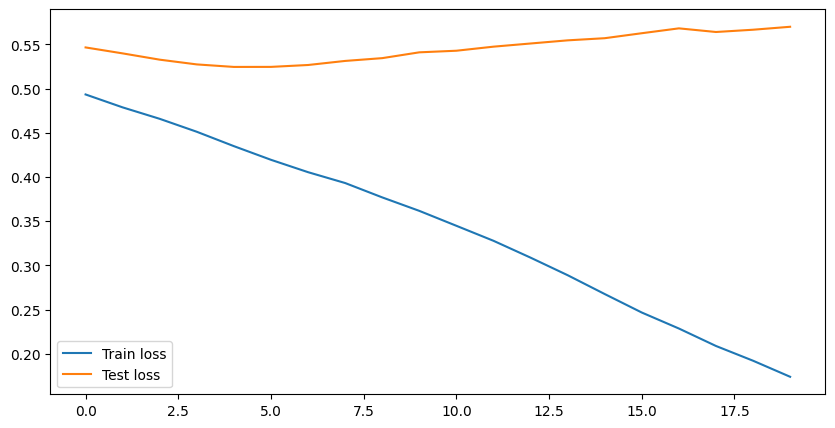

In [146]:
plt.plot(loss_values,label='Train loss')
plt.plot(loss_values_test, label='Test loss')
plt.legend()
plt.show()

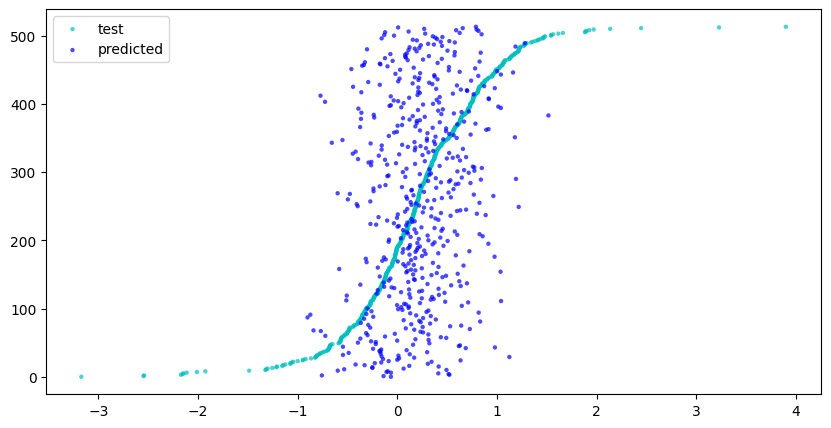

In [147]:
test_ordered = df.loc[test_i,['fingerprint', 'pca1']]
test_ordered['fingerprint'] = test_ordered.loc[:, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
test_tensor = torch.stack(tuple(list(test_ordered['fingerprint']))).to(device)
test_ordered['predictions'] = model1(test_tensor).cpu().detach().numpy()
test_ordered = test_ordered.sort_values(by='pca1')
plt.scatter(test_ordered.loc[:,'pca1'], range(len(test_ordered)), s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
plt.scatter(test_ordered.loc[:,'predictions'], range(len(test_ordered)), s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='predicted')
plt.legend()
plt.show()

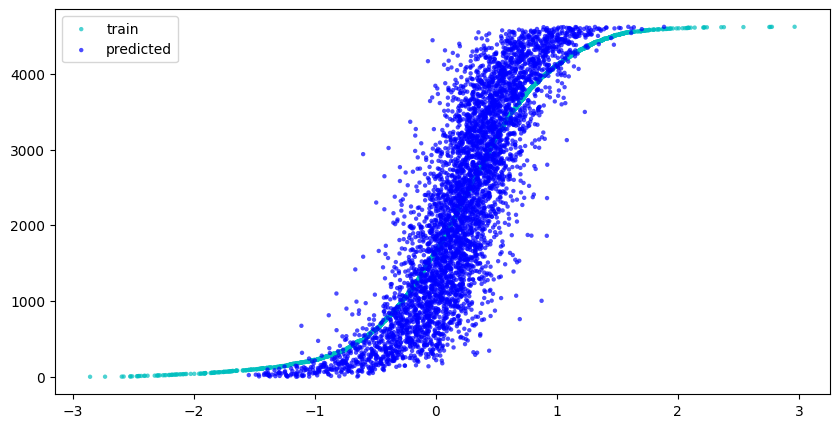

In [148]:
train_ordered = df.loc[train_i,['fingerprint', 'pca1']]
train_ordered['fingerprint'] = train_ordered.loc[:, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
train_tensor = torch.stack(tuple(list(train_ordered['fingerprint']))).to(device)
train_ordered['predictions'] = model1(train_tensor).cpu().detach().numpy()
train_ordered = train_ordered.sort_values(by='pca1')
plt.scatter(train_ordered.loc[:,'pca1'], range(len(train_ordered)), s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='train')
plt.scatter(train_ordered.loc[:,'predictions'], range(len(train_ordered)), s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='predicted')
plt.legend()
plt.show()

# CLASSIFICATION

In [292]:
# Classify multiple cut off values
cutoffs = [-1.4, -1.2, -1, -0.8]
for cutoff in cutoffs:
    label = f'cutoff{cutoff}'
    df[label] = np.nan
    print(label)
    df.loc[compounds_i, label] = df.loc[compounds_i, 'pca1'].apply(lambda x: x<cutoff).apply(lambda x: float(x))

cutoff-1.4
cutoff-1.2
cutoff-1
cutoff-0.8


In [787]:
df.head()

,cbkid,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,...,mode_of_action,target,morgan_fingerprint,pca1,pca2,fingerprint,cutoff-1.4,cutoff-1.2,cutoff-1,cutoff-0.8
0,CBK000155,-0.672208,-0.042178,-0.013539,-0.258297,0.063702,-0.248996,0.054097,-0.253403,0.058512,...,adrenergic receptor agonist,ADRB1|ADRB2|ADRB3,0100000000000001000000000000000001000000000000...,-0.440415,-1.917540,0100000000000001000000000000000001000000000000...,0.0,0.0,0.0,0.0
1,CBK000156,0.422168,-0.346389,-0.399594,-0.492103,-0.264450,-0.477399,-0.251773,-0.484836,-0.258669,...,adrenergic receptor agonist,ADRB1|ADRB2|ADRB3,0100000000000001000000001000000001000000000000...,0.175510,0.013852,0100000000000001000000001000000001000000000000...,0.0,0.0,0.0,0.0
2,CBK000161,0.395942,-0.151598,-0.134403,-0.513562,-0.724350,-0.511271,-0.718577,-0.512309,-0.722348,...,adrenergic receptor agonist,ADRB2,0100100000000000000000000000000001000000000000...,-0.010216,0.512785,0100100000000000000000000000000001000000000000...,0.0,0.0,0.0,0.0
3,CBK000162,-0.032411,-0.729416,-0.740183,2.712291,0.489569,2.722763,0.526429,2.717305,0.508454,...,adrenergic receptor antagonist,ADRB2|ADRB3,1100100000000000000000000000000001000000000000...,0.322076,-1.453096,1100100000000000000000000000000001000000000000...,0.0,0.0,0.0,0.0
4,CBK000164,0.216733,-0.543885,-0.540221,0.860705,0.898103,0.878953,0.916956,0.869954,0.907997,...,adrenergic receptor antagonist,ADRB1,0100100000000100000000000000000001000000000000...,0.582561,-0.171981,0100100000000100000000000000000001000000000000...,0.0,0.0,0.0,0.0


In [293]:
class FeedForwardNeuralNetModelClass(nn.Module):
    def __init__(self, input_dim, h_layers, output_dim, dropout=0.2, activation=nn.LeakyReLU()):
        super(FeedForwardNeuralNetModelClass, self).__init__()
        
        
        self.fc1 = nn.Linear(input_dim, h_layers[0])
        self.batch_norm = nn.BatchNorm1d(h_layers[0])
        self.activation1 = activation
        if activation != nn.SELU():
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.AlphaDropout(dropout)
        #self.dropout1 = self.dropout
        self.hidden_layers = []
        for index, n_nodes in enumerate(h_layers[:-1]):
            self.hidden_layers.append(nn.Linear(h_layers[index], h_layers[index+1]))
            self.hidden_layers.append(nn.BatchNorm1d(h_layers[index+1]))
            self.hidden_layers.append(activation)
            #self.hidden_layers.append(self.dropout)
            #self.hidden_layers.append(nn.AlphaDropout(dropout))
            #self.hidden_layers.append(nn.Dropout(dropout))
        self.fc_out = nn.Linear(h_layers[-1], output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.activation1(x)
        #x = self.dropout1(x)
        for layer in self.hidden_layers:
            x = layer(x)
        #nn.functional.batch_norm()
        x = self.fc_out(x)
        x = self.sigmoid(x)
        return x

In [296]:
# Create a NN that predics the coordinates in the 2D PCA space given the Morgan fingerprint

# Create iterable datasets
batch_size = 32
epochs = 30
normalize_data = False
iterations = epochs * n_train / batch_size
X_col = 'fingerprint'
y_col = 'cutoff-0.8'
train_dataset = MyDatasetFinger(df, train_thined_i, X_col, y_col, normalize_data)
test_dataset = MyDatasetFinger(df, test_i, X_col, y_col, normalize_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=n_test, shuffle=False)

# Create model
activation = nn.LeakyReLU()
input_dim = len(df.loc[compounds_i[0], X_col]) #1024
hidden_nodes = [20]
output_dim = 1
dropout = 0.0
model2 = FeedForwardNeuralNetModelClass(input_dim, hidden_nodes, output_dim, dropout=dropout, activation=activation)
# MSELoss for multi-output regression
criterion = nn.BCELoss()

learning_rate = 0.001
weight_decay = 0.0001
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)

iter = 0
loss_values = []
loss_values_test = []
best_model = np.nan
best_loss = math.inf
for epoch in range(epochs):
    running_loss = 0.0
    model2.train()
    for i, (fingerprints, target) in enumerate(train_loader):
        batch_size = len(fingerprints[0])
        #fingerprints = torch.stack(fingerprints).view(batch_size, 1024).requires_grad_().float()

        fingerprints = torch.transpose(torch.stack(fingerprints), 1, 0).float()
        optimizer.zero_grad()
        
        outputs = model2(fingerprints)

        #print(f"outputs type: {outputs[0, 0]}")
        #print(f"cutoff type: {target[0]}")
        loss = criterion(outputs, target.view(len(target), 1).float())
        running_loss += loss.item() * batch_size
        
        loss.backward()
        
        optimizer.step()
        
        iter += 1
    model2.eval()
    for i, (fingerprints_test, target) in enumerate(test_loader):
        test_size = len(fingerprints_test[0])
        fingerprints_test = torch.transpose(torch.stack(fingerprints_test), 1, 0).float()
        outputs_test = model2(fingerprints_test)
        loss_test = criterion(outputs_test, target.view(len(target), 1).float())
        loss_values_test.append(loss_test.item())
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model2)
            
    loss_values.append(running_loss / n_train)
    print(f"epoch {epoch}/{epochs}")
    print(f"Train loss: {loss_values[-1]}\tTest loss: {loss_values_test[-1]}")
print("DONE =)")
print(f"Best test loss: {best_loss}")
model2 = best_model

epoch 0/30
Train loss: 0.3727000974726558	Test loss: 0.4333898723125458
epoch 1/30
Train loss: 0.22132095550722025	Test loss: 0.3098558783531189
epoch 2/30
Train loss: 0.158611392541459	Test loss: 0.2667650878429413
epoch 3/30
Train loss: 0.12418754891228609	Test loss: 0.2605750560760498
epoch 4/30
Train loss: 0.10040731384650475	Test loss: 0.2650015950202942
epoch 5/30
Train loss: 0.08272111431341413	Test loss: 0.2798471748828888
epoch 6/30
Train loss: 0.06652642142537919	Test loss: 0.2881103456020355
epoch 7/30
Train loss: 0.05508389017768196	Test loss: 0.30426767468452454
epoch 8/30
Train loss: 0.042992310667419764	Test loss: 0.32146647572517395
epoch 9/30
Train loss: 0.03461579765315903	Test loss: 0.3366301357746124
epoch 10/30
Train loss: 0.02748964498618856	Test loss: 0.346384197473526
epoch 11/30
Train loss: 0.021771151474919884	Test loss: 0.36611565947532654
epoch 12/30
Train loss: 0.017691145598037087	Test loss: 0.3748859465122223
epoch 13/30
Train loss: 0.014864173561199174	T

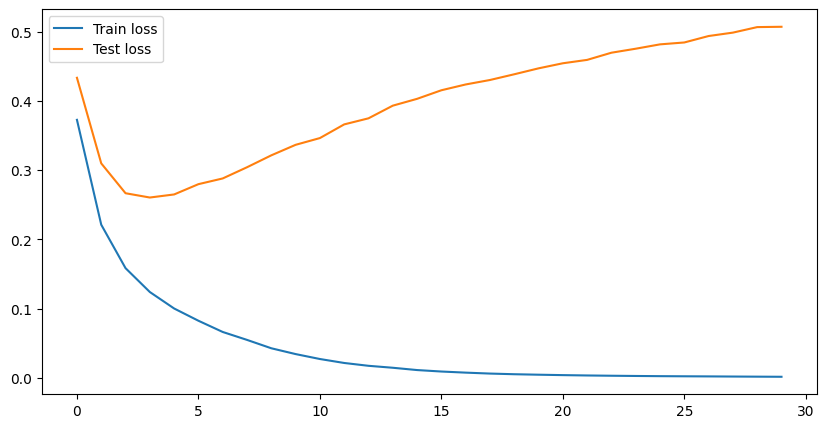

In [300]:
plt.plot(loss_values,label='Train loss')
plt.plot(loss_values_test, label='Test loss')
plt.legend()
plt.show()

In [301]:
# Test data confusion matrix
temp = df.loc[test_i, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
temp = tuple(temp)
test_finger = torch.stack(temp)
test_pred = best_model(test_finger)
test_pred = [1 if pred>0.5 else 0 for pred in test_pred]
confusion_matrix = pd.crosstab(df.loc[test_i, 'cutoff-0.8'], test_pred)
confusion_matrix

col_0,0,1
cutoff-0.8,,
0.0,479,3
1.0,32,0


In [302]:
# Train data confusion matrix
temp = df.loc[train_thined_i, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
temp = tuple(temp)
train_finger = torch.stack(temp)
train_pred = best_model(train_finger)
train_pred = [1 if pred>0.5 else 0 for pred in train_pred]
confusion_matrix = pd.crosstab(df.loc[train_thined_i, 'cutoff-0.8'], train_pred)
confusion_matrix

col_0,0,1
cutoff-0.8,,
0.0,2552,0
1.0,190,130


In [584]:
temp = df.loc[test_i, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
temp = tuple(temp)
test_finger = torch.stack(temp)
test_pred = best_model(test_finger)
print(test_pred)

tensor([[0.0390],
        [0.0197],
        [0.1208],
        [0.0391],
        [0.0241],
        [0.2848],
        [0.0151],
        [0.0481],
        [0.0195],
        [0.0235],
        [0.0508],
        [0.1005],
        [0.0448],
        [0.1699],
        [0.0082],
        [0.0434],
        [0.0086],
        [0.1418],
        [0.0183],
        [0.0675],
        [0.1134],
        [0.1971],
        [0.0776],
        [0.4572],
        [0.4329],
        [0.1659],
        [0.4313],
        [0.2593],
        [0.0770],
        [0.0650],
        [0.1029],
        [0.0417],
        [0.0399],
        [0.1321],
        [0.1016],
        [0.0075],
        [0.0096],
        [0.0474],
        [0.0131],
        [0.0705],
        [0.0320],
        [0.0184],
        [0.1285],
        [0.1548],
        [0.0345],
        [0.2845],
        [0.0276],
        [0.0797],
        [0.0051],
        [0.1591],
        [0.0812],
        [0.0020],
        [0.0049],
        [0.1027],
        [0.0408],
        [0

# MORPHOLOGICAL PROFILES NN

In [62]:
class MyDatasetMorph(torch.utils.data.Dataset):
    # Holds morphological profile as x
    # as y PCA1
    def __init__(self, df, rows, X, Y, scale=False, get_index=False):
        self.x = torch.tensor(df.loc[rows, X].values).float().to(device)
        self.y = torch.tensor(df.loc[rows, Y].values).float().to(device)
        # Normalize the Y values
        if scale:
#            absolute_largest = self.y.abs().max()
            self.y = self.y / scale
#            for column in self.y.columns:
#                self.y[column] = (self.y[column] - self.y[column].mean()) / self.y[column].std()
        # Index in original df
        self.get_index = get_index
        self.index = rows
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [120]:
class FeedForwardNeuralNetModelMorph(nn.Module):
    def __init__(self, input_dim, h_layers, output_dim, dropout=0.2, activation=nn.LeakyReLU()):
        super(FeedForwardNeuralNetModelMorph, self).__init__()
        
        self.morph_input = nn.Linear(input_dim, h_layers[0])
        #self.batch_norm = nn.BatchNorm1d(h_layers[0])
        self.activation1 = activation
        if activation != nn.SELU():
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.AlphaDropout(dropout)
        self.dropout1 = self.dropout
        self.hidden_layers = nn.ModuleList()
        for index, n_nodes in enumerate(h_layers[:-1]):
            self.hidden_layers.append(nn.Linear(h_layers[index], h_layers[index+1]))
            #self.hidden_layers.append(nn.BatchNorm1d(h_layers[index+1]))
            self.hidden_layers.append(activation)
            self.hidden_layers.append(self.dropout)
            #self.hidden_layers.append(nn.AlphaDropout(dropout))
            #self.hidden_layers.append(nn.Dropout(dropout))
        self.fc_out = nn.Linear(h_layers[-1], output_dim)
        
    def forward(self, x):
        x = self.morph_input(x)
        #x = self.batch_norm(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        for layer in self.hidden_layers:
            x = layer(x)
        #nn.functional.batch_norm()
        x = self.fc_out(x)
        return x.to(device)

In [284]:
# Create a NN that predics the coordinates in the PC1 space given the Morphological profiles

# Create iterable datasets
batch_size = 32
epochs = 20
X = morph_i
y = 'pca1'
# Scale data between [-1, 1]
scale_value = df.loc[compounds_i, 'pca1'].abs().max()
iterations = epochs * len(train_i) / batch_size
train_dataset = MyDatasetMorph(df, train_i, X, y)
test_dataset = MyDatasetMorph(df, test_i, X, y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=n_test, shuffle=False)

# Create model
activation = nn.LeakyReLU()

input_dim = len(morph_i)
hidden_nodes = [200]
output_dim = 1
dropout = 0.5
model_morph = FeedForwardNeuralNetModelMorph(input_dim, hidden_nodes, output_dim, dropout=dropout, activation=activation).to(device)
model_morph = model_morph.to(device)
# MSELoss for multi-output regression
criterion = nn.MSELoss()

learning_rate = 0.0001
weight_decay = 0.1# l2 regression
optimizer = torch.optim.Adam(model_morph.parameters(), lr=learning_rate, weight_decay=weight_decay)

iter = 0
loss_values = []
loss_values_test = []
best_model = np.nan
best_loss = math.inf

print(next(model_morph.parameters()).device)

for epoch in range(epochs):
    running_loss = 0.0
    model_morph.train()
    model_morph = model_morph.to(device)
    for i, (morph_profil, PCA1) in enumerate(train_loader):
        batch_size = len(morph_profil[0])
        #fingerprints = torch.stack(fingerprints).view(batch_size, 1024).requires_grad_().float()

        #morph_profil = torch.transpose(torch.stack(morph_profil), 1, 0).float().to(device)
        PCA = PCA1.float().to(device)
        optimizer.zero_grad()
        

        #print(f"target is cuda: {PCA1.is_cuda}")
        #print(f"fingerprint is cuda: {fingerprints.is_cuda}"
        outputs = model_morph(morph_profil)

        loss = criterion(outputs, PCA.view([len(PCA), 1]))
        running_loss += loss.item() * batch_size
        
        loss.backward()
        
        optimizer.step()
        
        iter += 1
    model_morph.eval()
    for i, (morph_profil_test, PCA1_test) in enumerate(test_loader):
        test_size = len(morph_profil_test[0])
        #fingerprints_test = torch.stack(fingerprints_test).view(test_size, 1024).requires_grad_().float()
        #morph_profil_test = torch.transpose(torch.stack(morph_profil_test), 1, 0).float().to(device)
        #PCA_test = torch.stack((PCA1_test, PCA2_test)).view(test_size, 2)
        #PCA_test = torch.transpose(torch.stack((PCA1_test)), 1, 0).float()
        
        PCA_test = PCA1_test.to(device)
        outputs_test = model_morph(morph_profil_test)
        loss_test = criterion(outputs_test, PCA_test.view([len(PCA_test), 1]))
        loss_values_test.append(loss_test.item())
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model_morph)
            
            
    loss_values.append(running_loss / n_train)
    print(f"epoch {epoch}/{epochs}")
    print(f"Train loss: {loss_values[-1]}\tTest loss: {loss_values_test[-1]}")
print("DONE =)")
print(f"Best test loss: {best_loss}")
model_morph = best_model

cuda:0
epoch 0/20
Train loss: 3.337072942707445	Test loss: 0.007529969792813063
epoch 1/20
Train loss: 1.3413945802825418	Test loss: 0.003768720431253314
epoch 2/20
Train loss: 0.8574944418266309	Test loss: 0.004511012230068445
epoch 3/20
Train loss: 0.7474792115301623	Test loss: 0.0022919720504432917
epoch 4/20
Train loss: 0.5923034292864425	Test loss: 0.001775772892870009
epoch 5/20
Train loss: 0.5992822386161157	Test loss: 0.004870586562901735
epoch 6/20
Train loss: 0.5929684481780845	Test loss: 0.0013818425359204412
epoch 7/20
Train loss: 0.6365377095298593	Test loss: 0.00840967707335949
epoch 8/20
Train loss: 0.5705379155239046	Test loss: 0.0012649866985157132
epoch 9/20
Train loss: 0.5447921595520855	Test loss: 0.0012263975804671645
epoch 10/20
Train loss: 0.5314226579029911	Test loss: 0.0017848677234724164
epoch 11/20
Train loss: 0.45825695709010567	Test loss: 0.00122471759095788
epoch 12/20
Train loss: 0.4569323343825215	Test loss: 0.004135391674935818
epoch 13/20
Train loss: 0

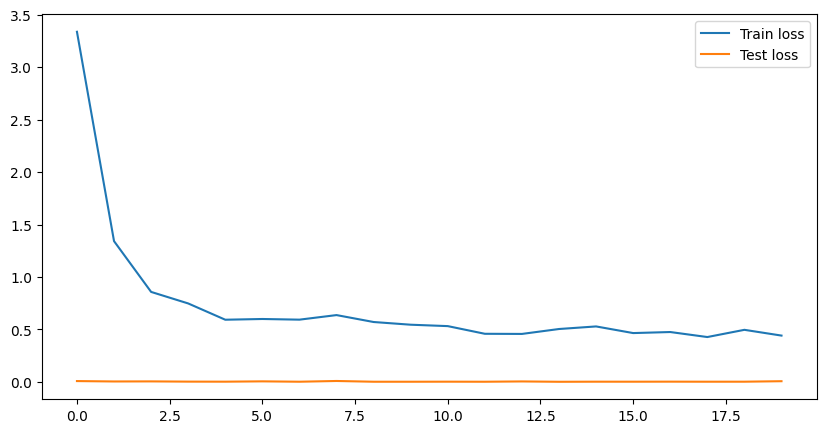

In [285]:
plt.plot(loss_values,label='Train loss')
plt.plot(loss_values_test, label='Test loss')
plt.legend()
plt.show()

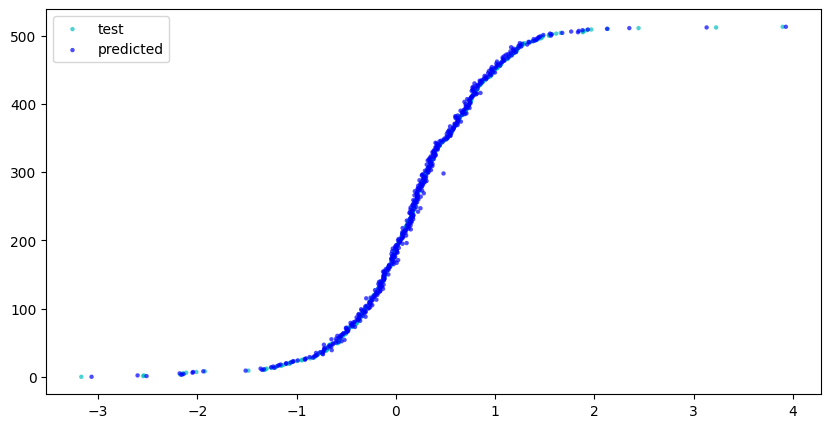

In [286]:
test_ordered = df.loc[test_i, morph_i]
test_ordered['pca1'] = df.loc[test_i, 'pca1']
test_tensor = torch.tensor(test_ordered.loc[:, morph_i].to_numpy()).float().to(device)
test_ordered['predictions'] = model_morph(test_tensor).cpu().detach().numpy()
test_ordered = test_ordered.sort_values(by='pca1')
plt.scatter(test_ordered.loc[:,'pca1'], range(len(test_ordered)), s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
plt.scatter(test_ordered.loc[:,'predictions'], range(len(test_ordered)), s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='predicted')
plt.legend()
plt.show()

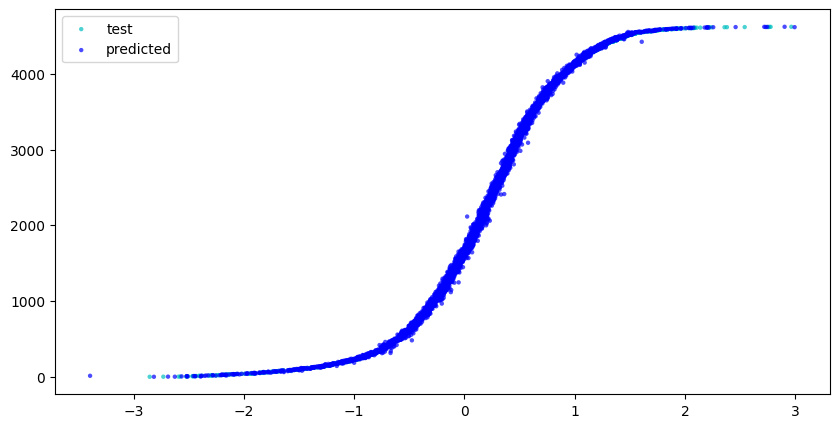

In [287]:
train_ordered = df.loc[train_i, morph_i]
train_ordered['pca1'] = df.loc[train_i, 'pca1']
train_tensor = torch.tensor(train_ordered.loc[:, morph_i].to_numpy()).float().to(device)
train_ordered['predictions'] = model_morph(train_tensor).cpu().detach().numpy()
train_ordered = train_ordered.sort_values(by='pca1')
plt.scatter(train_ordered.loc[:,'pca1'], range(len(train_ordered)), s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
plt.scatter(train_ordered.loc[:,'predictions'], range(len(train_ordered)), s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='predicted')
plt.legend()
plt.show()

# TRANSFER LEARNING

In [103]:
# Freez all layers in morphological model
for param in model_morph.parameters():
    param.requires_grad = False

In [108]:
for param in model_morph.parameters():
    print(param.shape)

torch.Size([500, 1878])
torch.Size([500])
torch.Size([100, 500])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [109]:
type(model_morph.parameters())

generator

In [128]:
model_morph_dict = model_morph.state_dict()
for key in sorted(model_morph_dict):
    parameter = model_morph_dict[key]
    print(key)
    print(parameter.size())
print('-'*20)
model1_dict = model1.state_dict()
for key in sorted(model1_dict):
    parameter = model1_dict[key]
    print(key)
    print(parameter.size())

fc_out.bias
torch.Size([1])
fc_out.weight
torch.Size([1, 100])
hidden_layers.0.bias
torch.Size([100])
hidden_layers.0.weight
torch.Size([100, 500])
morph_input.bias
torch.Size([500])
morph_input.weight
torch.Size([500, 1878])
--------------------
fc1.bias
torch.Size([500])
fc1.weight
torch.Size([500, 1024])
fc_out.bias
torch.Size([1])
fc_out.weight
torch.Size([1, 100])
hidden_layers.0.bias
torch.Size([100])
hidden_layers.0.weight
torch.Size([100, 500])


In [166]:
# Create iterable datasets
batch_size = 32
epochs = 20
# Scale data between [-1, 1]
scale_value = df.loc[compounds_i, 'pca1'].abs().max()
iterations = epochs * len(train_i) / batch_size
train_dataset = MyDatasetFinger(df, train_i, 'fingerprint', 'pca1')
test_dataset = MyDatasetFinger(df, test_i, 'fingerprint', 'pca1')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=n_test, shuffle=False)

# Create model
activation = nn.LeakyReLU()
input_dim = len(df.loc[compounds_i[0], 'fingerprint']) #1024
hidden_nodes = [200]
output_dim = 1
dropout = 0.2
model1 = FeedForwardNeuralNetModelReg(input_dim, hidden_nodes, output_dim, dropout=dropout, activation=activation)
model1 = model1.to(device)

# Add layers from model trained on morphological profiles

"""model_morph_dict = model_morph.state_dict()
model1_dict = model1.state_dict()
# Filter out keys
model_morph_dict = {k: v for k, v in model_morph_dict.items() if k in model1_dict}
model1_dict.update(model_morph_dict)
model1.load_state_dict(model1_dict)
model1.train()
"""

'model_morph_dict = model_morph.state_dict()\nmodel1_dict = model1.state_dict()\n# Filter out keys\nmodel_morph_dict = {k: v for k, v in model_morph_dict.items() if k in model1_dict}\nmodel1_dict.update(model_morph_dict)\nmodel1.load_state_dict(model1_dict)\nmodel1.train()\n'

In [136]:

model1_dict = model1.state_dict()
for key in sorted(model1_dict):
    parameter = model1_dict[key]
    print(key)
    print(parameter.size())
    print(parameter.requires_grad)

fc1.bias
torch.Size([500])
False
fc1.weight
torch.Size([500, 1024])
False
fc_out.bias
torch.Size([1])
False
fc_out.weight
torch.Size([1, 100])
False
hidden_layers.0.bias
torch.Size([100])
False
hidden_layers.0.weight
torch.Size([100, 500])
False


In [289]:
# Create a NN that predics the coordinates in the 2D PCA space given the Morgan fingerprint

# Create iterable datasets
batch_size = 32
epochs = 20
# Scale data between [-1, 1]
scale_value = df.loc[compounds_i, 'pca1'].abs().max()
iterations = epochs * len(train_i) / batch_size
train_dataset = MyDatasetFinger(df, train_i, 'fingerprint', 'pca1')
test_dataset = MyDatasetFinger(df, test_i, 'fingerprint', 'pca1')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=n_test, shuffle=False)

# Create model
activation = nn.LeakyReLU()
input_dim = len(df.loc[compounds_i[0], 'fingerprint']) #1024
hidden_nodes = [200]
output_dim = 1
dropout = 0.2
model1 = FeedForwardNeuralNetModelReg(input_dim, hidden_nodes, output_dim, dropout=dropout, activation=activation)
model1 = model1.to(device)

# Add layers from model trained on morphological profiles
model_morph_dict = model_morph.state_dict()
model1_dict = model1.state_dict()
model1_frozen_keys = [key for key in model_morph_dict if key in model1_dict]
model_morph_dict = {k: v for k, v in model_morph_dict.items() if k in model1_dict}
model1_dict.update(model_morph_dict)
model1.load_state_dict(model1_dict)
model1 = model1.to(device)


# MSELoss for multi-output regression
criterion = nn.MSELoss()

learning_rate = 0.0005
weight_decay = 0.0# l2 regression
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=weight_decay)

iter = 0
loss_values = []
loss_values_test = []
best_model = np.nan
best_loss = math.inf

print(next(model1.parameters()).device)

for epoch in range(epochs):
    running_loss = 0.0
    model1.train()
    for name, param in model1.named_parameters():
        if name in model1_frozen_keys:
            param.requires_grad = False
    model1 = model1.to(device)
    for i, (fingerprints, PCA1) in enumerate(train_loader):
        batch_size = len(fingerprints[0])
        #fingerprints = torch.stack(fingerprints).view(batch_size, 1024).requires_grad_().float()

        fingerprints = torch.transpose(torch.stack(fingerprints), 1, 0).float().to(device)
        PCA = PCA1.float().to(device)
        optimizer.zero_grad()
        

        #print(f"target is cuda: {PCA1.is_cuda}")
        #print(f"fingerprint is cuda: {fingerprints.is_cuda}")
        outputs = model1(fingerprints)

        loss = criterion(outputs, PCA.view([len(PCA), 1]))
        running_loss += loss.item() * batch_size
        
        loss.backward()
        
        optimizer.step()
        
        iter += 1
    model1.eval()
    for i, (fingerprints_test, PCA1_test) in enumerate(test_loader):
        test_size = len(fingerprints_test[0])
        #fingerprints_test = torch.stack(fingerprints_test).view(test_size, 1024).requires_grad_().float()
        fingerprints_test = torch.transpose(torch.stack(fingerprints_test), 1, 0).float().to(device)
        #PCA_test = torch.stack((PCA1_test, PCA2_test)).view(test_size, 2)
        #PCA_test = torch.transpose(torch.stack((PCA1_test)), 1, 0).float()
        
        PCA_test = PCA1_test.to(device)
        outputs_test = model1(fingerprints_test)
        loss_test = criterion(outputs_test, PCA_test.view([len(PCA_test), 1]))
        loss_values_test.append(loss_test.item())
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model1)
            
            
    loss_values.append(running_loss / n_train)
    print(f"epoch {epoch}/{epochs}")
    print(f"Train loss: {loss_values[-1]}\tTest loss: {loss_values_test[-1]}")
print("DONE =)")
print(f"Best test loss: {best_loss}")

cuda:0
epoch 0/20
Train loss: 0.48580526609076125	Test loss: 0.5333234545581444
epoch 1/20
Train loss: 0.4454744770732748	Test loss: 0.5278364566557155
epoch 2/20
Train loss: 0.4163271623226864	Test loss: 0.5281312936976
epoch 3/20
Train loss: 0.39334270437412305	Test loss: 0.5306981789652767
epoch 4/20
Train loss: 0.37453580661734265	Test loss: 0.5336436154068136
epoch 5/20
Train loss: 0.3599586131910152	Test loss: 0.5370375906374083
epoch 6/20
Train loss: 0.3465584949984279	Test loss: 0.5406326775604995
epoch 7/20
Train loss: 0.33523423869458663	Test loss: 0.543358732924999
epoch 8/20
Train loss: 0.3240751084847204	Test loss: 0.5461849325748266
epoch 9/20
Train loss: 0.3155179258788259	Test loss: 0.5490873317043969
epoch 10/20
Train loss: 0.3061748013703293	Test loss: 0.5522894328204544
epoch 11/20
Train loss: 0.2978691291326028	Test loss: 0.5543033106070694
epoch 12/20
Train loss: 0.2902491993684579	Test loss: 0.5570830569467129
epoch 13/20
Train loss: 0.2806606391560487	Test loss: 

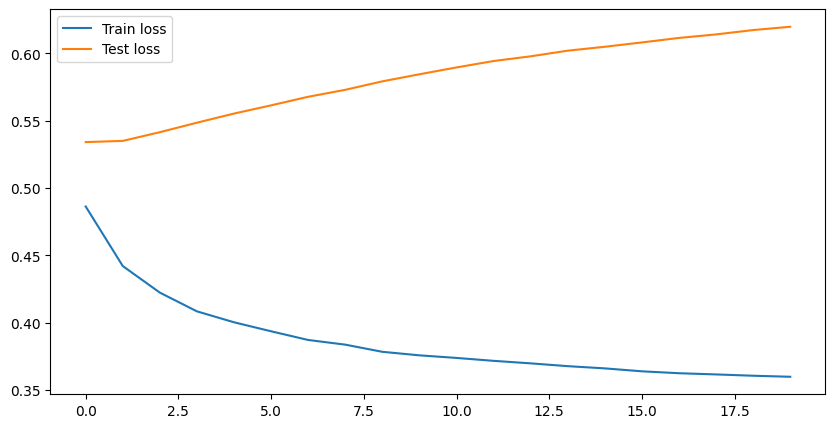

In [281]:
plt.plot(loss_values,label='Train loss')
plt.plot(loss_values_test, label='Test loss')
plt.legend()
plt.show()

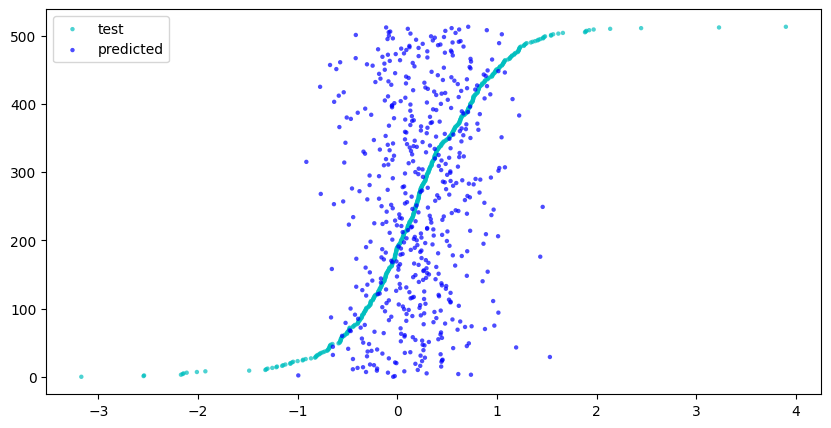

In [282]:
test_ordered = df.loc[test_i,['fingerprint', 'pca1']]
test_ordered['fingerprint'] = test_ordered.loc[:, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
test_tensor = torch.stack(tuple(list(test_ordered['fingerprint']))).to(device)
test_ordered['predictions'] = model1(test_tensor).cpu().detach().numpy()
test_ordered = test_ordered.sort_values(by='pca1')
plt.scatter(test_ordered.loc[:,'pca1'], range(len(test_ordered)), s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='test')
plt.scatter(test_ordered.loc[:,'predictions'], range(len(test_ordered)), s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='predicted')
plt.legend()
plt.show()

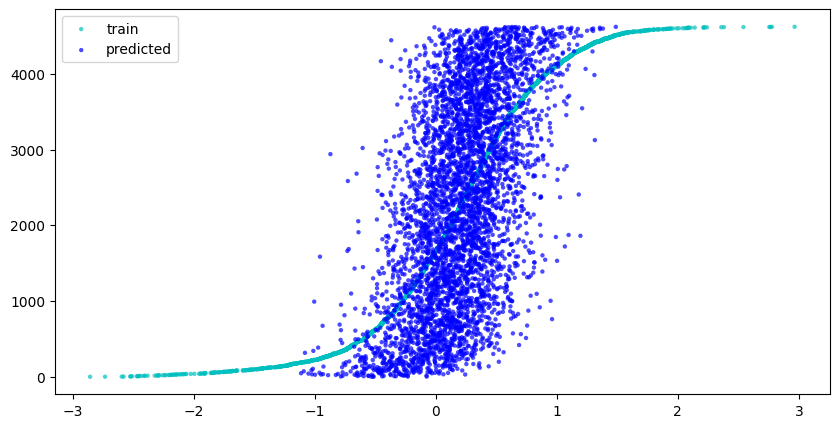

In [283]:
train_ordered = df.loc[train_i,['fingerprint', 'pca1']]
train_ordered['fingerprint'] = train_ordered.loc[:, 'fingerprint'].apply(lambda finger: torch.Tensor(list(map(int, [*finger]))))
train_tensor = torch.stack(tuple(list(train_ordered['fingerprint']))).to(device)
train_ordered['predictions'] = model1(train_tensor).cpu().detach().numpy()
train_ordered = train_ordered.sort_values(by='pca1')
plt.scatter(train_ordered.loc[:,'pca1'], range(len(train_ordered)), s=size, c='c', edgecolor=edgecolor, alpha=alpha, label='train')
plt.scatter(train_ordered.loc[:,'predictions'], range(len(train_ordered)), s=size, c='b', edgecolor=edgecolor, alpha=alpha, label='predicted')
plt.legend()
plt.show()

In [192]:
model_morph_dict = model_morph.state_dict()
for key in sorted(model_morph_dict):
    parameter = model_morph_dict[key]
    print(key)
    print(parameter.size())
print('-'*20)
model1_dict = model1.state_dict()
for key in sorted(model1_dict):
    parameter = model1_dict[key]
    print(key)
    print(parameter.size())

fc_out.bias
torch.Size([1])
fc_out.weight
torch.Size([1, 200])
hidden_layers.0.bias
torch.Size([200])
hidden_layers.0.weight
torch.Size([200, 500])
morph_input.bias
torch.Size([500])
morph_input.weight
torch.Size([500, 1878])
--------------------
fc1.bias
torch.Size([500])
fc1.weight
torch.Size([500, 1024])
fc_out.bias
torch.Size([1])
fc_out.weight
torch.Size([1, 200])
hidden_layers.0.bias
torch.Size([200])
hidden_layers.0.weight
torch.Size([200, 500])


In [257]:
model_morph_dict['fc_out.weight'] == model1_dict['fc_out.weight']

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, T

In [256]:
model_morph_dict['hidden_layers.0.weight'] == model1_dict['hidden_layers.0.weight']

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [255]:
model_morph_dict['hidden_layers.0.bias'] == model1_dict['hidden_layers.0.bias']

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [186]:
model1_frozen_keys

['hidden_layers.0.weight',
 'hidden_layers.0.bias',
 'fc_out.weight',
 'fc_out.bias']

In [200]:
for name, param in model1.named_parameters():
    print(name)
    if name in model1_frozen_keys:
        print('FREEZ')

fc1.weight
fc1.bias
hidden_layers.0.weight
FREEZ
hidden_layers.0.bias
FREEZ
fc_out.weight
FREEZ
fc_out.bias
FREEZ
